First attempt of implementing Unet for a segmentation mask

In [ ]:
import keras
keras.__version__

'2.9.0'

In [ ]:
!python --version
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --config python3
!python3 --version
!sudo apt install python3-pip


Python 3.8.16
update-alternatives: error: alternative path /usr/bin/python3.7 doesn't exist
There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.8   2         auto mode
  1            /usr/bin/python3.6   1         manual mode
  2            /usr/bin/python3.8   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
update-alternatives: using /usr/bin/python3.6 to provide /usr/bin/python3 (python3) in manual mode
Python 3.6.9
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-cry

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# !pip install visualkeras
# import visualkeras

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import exposure
from skimage import filters

import matplotlib.pyplot as plt

from google.colab import drive
# drive.mount('/content/gdrive')

seed = 42
np.random.seed = seed

IMG_WIDTH = 128 * 3
IMG_HEIGHT = 128 * 6 
# IMG_CHANNELS = 3

TRAIN_PATH = '/content/drive/MyDrive/Universiteit Utrecht - Drive/Stage/Attempt_1_combo'
TEST_PATH = '/content/drive/MyDrive/Universiteit Utrecht - Drive/Stage/Attempt_1_test'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[2]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
X_train_flip = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
Y_train_flip = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + "/" + id_ + "/"
    
    image_name = sorted(next(os.walk(path))[2])[0] # The [0] here indicates the original image
    img = cv2.imread(path + image_name, 0) 
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    # percentiles = np.percentile(img, (25, 65))
    # img = exposure.rescale_intensity(img,
    #                                 in_range=tuple(percentiles))
    # img = exposure.adjust_gamma(img, gamma=0.90,gain=1)
    # val = filters.threshold_otsu(img)
    # mask = img < val

    X_train[n] = img  #Fill empty X_train with values from img
    # flipped_X= cv2.flip(img, 1)
    # X_train_flip[n] = flipped_X

    # for j in range(len(1,next(os.walk(path)))):
    #   mask_name = sorted(next(os.walk(path))[2][j]) # The [1] here indicates the mask image
    #   mask = cv2.imread(path + mask_name, 0)  
    #   mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in sorted(next(os.walk(path))[2])[1:]:
        mask_ = cv2.imread(path + mask_file, 0)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        # cv2_imshow(mask)
    mask = np.squeeze(mask)

    Y_train[n] = mask
    # flipped_Y= cv2.flip(mask, 1)
    # Y_train_flip[n] = flipped_Y

# X_train = np.concatenate((X_train, X_train_flip))
# Y_train = np.concatenate((Y_train, Y_train_flip))



/usr/lib/python3/dist-packages/Crypto/Random/Fortuna/FortunaGenerator.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sys.version_info[0] is 2 and  sys.version_info[1] is 1:
/usr/lib/python3/dist-packages/Crypto/Random/Fortuna/FortunaGenerator.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sys.version_info[0] is 2 and  sys.version_info[1] is 1:
<ipython-input-2-849d40c9f09c>:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
<ipython-input-2-849d40c9f09c>:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warnin

Resizing training images and masks


  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-2-849d40c9f09c>:65: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████| 200/200 [08:51<00:00,  2.66s/it]


In [ ]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)): 
    path = TEST_PATH + "/"
    # test_name = next(os.walk(path))[2][n]
    test_name = os.listdir(path)[n]
    # print(len(os.listdir(path)))
    img = cv2.imread(path + str(test_name),0) 
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    # img = exposure.adjust_gamma(img, gamma=0.50,gain=1)
    # percentiles = np.percentile(img, (0.5, 48))
    # img = exposure.rescale_intensity(img,
    #                                 in_range=tuple(percentiles))
    # # img = exposure.equalize_hist(img)
    # val = filters.threshold_otsu(img)
    # mask = img < val
    X_test[n] = img

print('Done!')

# plt.imshow(X_test[0])
print(len(X_test))

In [ ]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)

TEST_PATH = '/content/drive/MyDrive/Universiteit Utrecht - Drive/Stage/attempt_1_test_complete'
test_ids = next(os.walk(TEST_PATH))[1]


for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + "/" + id_ + "/"
    image_name = next(os.walk(path))[2][0] # The [0] here indicates the original image

    img = cv2.imread(path + image_name, 0) 
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X_test[n] = img  #Fill empty X_train with values from img

    mask_name = next(os.walk(path))[2][1] # The [1] here indicates the mask image
    mask = cv2.imread(path + mask_name, 0)  
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    Y_test[n] = mask


<ipython-input-12-395c86cb7d25>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
100%|██████████| 10/10 [00:00<00:00, 14.08it/s]


8


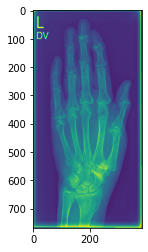

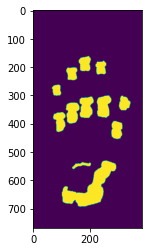

In [ ]:
# Sanity Check
# image_x = random.randint(0, len(X_train))
image_x = 8
print(image_x)
plt.imshow(X_test[image_x])
plt.show()
plt.imshow(Y_test[image_x])
plt.show()

In [ ]:
import keras.backend as K
# Custom loss function
def DiceLoss(targets, inputs, smooth=1e-6):
    #flatten label and prediction tensors
    # inputs = K.flatten(inputs)
    # targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def diceLoss(pred, true):
  pred = K.l2_normalize(pred)
  true = K.l2_normalize(true)
  diffFP = pred - true
  diffFN = true - pred
  TP2 = K.sum(pred - diffFP - diffFN) * 2.0
  TP = pred - diffFP - diffFN
  dice = TP2 / (TP2 + K.sum(diffFP) + K.sum(diffFN))
  return 1 - dice

def diceloss(mask1, mask2):
    intersect = K.sum(mask1*mask2)
    fsum = K.sum(mask1)
    ssum = K.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = K.mean(dice)
    # dice = round(dice, 3) # for easy reading
    return dice  

In [ ]:
# #Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH,1))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

X_train = X_train.reshape(len(X_train), IMG_HEIGHT, IMG_WIDTH,1)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_hand_scan.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=10, epochs=25, callbacks=callbacks)



Epoch 1/25
18/18 [==============================] - 22s 457ms/step - loss: 0.4861 - accuracy: 0.8584 - val_loss: 0.3568 - val_accuracy: 0.8888
Epoch 2/25
18/18 [==============================] - 8s 439ms/step - loss: 0.3196 - accuracy: 0.8778 - val_loss: 0.2717 - val_accuracy: 0.8888
Epoch 3/25
18/18 [==============================] - 8s 441ms/step - loss: 0.2509 - accuracy: 0.8778 - val_loss: 0.2368 - val_accuracy: 0.8888
Epoch 4/25
18/18 [==============================] - 8s 441ms/step - loss: 0.2303 - accuracy: 0.8778 - val_loss: 0.2337 - val_accuracy: 0.8888
Epoch 5/25
18/18 [==============================] - 8s 446ms/step - loss: 0.2277 - accuracy: 0.8778 - val_loss: 0.2331 - val_accuracy: 0.8888
Epoch 6/25
18/18 [==============================] - 8s 445ms/step - loss: 0.2165 - accuracy: 0.8779 - val_loss: 0.2173 - val_accuracy: 0.8889
Epoch 7/25
18/18 [==============================] - 8s 450ms/step - loss: 0.2103 - accuracy: 0.8781 - val_loss: 0.2241 - val_accuracy: 0.8885
Epoch

In [ ]:
# tf.keras.backend.clear_session()

from tensorflow.keras.models import load_model
savePath = '/content/drive/MyDrive/Universiteit Utrecht - Drive/Stage'

model = load_model(savePath + '/U4_T150_3x6.h5')

2/2 [==============================] - 0s 169ms/step


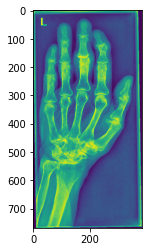

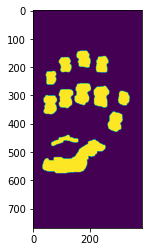

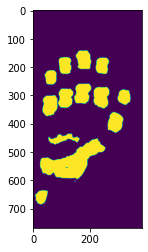

In [ ]:
####################################
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train, batch_size=10 ,verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], batch_size=10, verbose=1)
# preds_test = model.predict(X_test, batch_size=10, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
# ix = random.randint(0, len(preds_train_t))
ix = 189
plt.imshow(np.squeeze(X_train[ix]))
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# plt.imshow(np.squeeze(X_test[1]))
# plt.show()
# plt.imshow(np.squeeze(preds_test_t)[1])
# plt.show()

# plt.imshow(np.squeeze(X_test[2]))
# plt.show()
# plt.imshow(np.squeeze(preds_test_t)[2])
# plt.show()

clean_pred_train = []
from google.colab.patches import cv2_imshow
for i in range(len(Y_train)):
  # cv2_imshow(X_test[1])
  # cv2_imshow(Y_test[1])
  plt.imsave('test.png', np.squeeze(preds_train_t)[i])
  prediction = cv2.imread('test.png', 0)
  percentiles = np.percentile(prediction, (40, 99))
  prediction = exposure.rescale_intensity(prediction,
                                  in_range=tuple(percentiles))
  prediction = exposure.adjust_gamma(prediction, gamma=0.90,gain=1)

  clean_pred_train.append(prediction)
  # cv2_imshow(prediction)

# clean_pred_test = []
# from google.colab.patches import cv2_imshow
# for i in range(len(Y_test)):
#   # cv2_imshow(X_test[1])
#   # cv2_imshow(Y_test[1])
#   plt.imsave('test.png', np.squeeze(preds_test_t)[i])
#   prediction = cv2.imread('test.png', 0)
#   percentiles = np.percentile(prediction, (40, 99))
#   prediction = exposure.rescale_intensity(prediction,
#                                   in_range=tuple(percentiles))
#   prediction = exposure.adjust_gamma(prediction, gamma=0.90,gain=1)

#   clean_pred_test.append(prediction)



# # Perform a sanity check on some random validation samples
# ix = random.randint(0, len(preds_val_t))
# plt.imshow(np.squeeze(X_train[int(X_train.shape[0]*0.9):][ix]))
# plt.show()
# plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
# plt.show()
# plt.imshow(np.squeeze(preds_val_t[ix]))
# plt.show()

In [ ]:
# cv2_imshow(clean_pred[(9)])
for i in range(len(preds_train_t)):
  print(i)
  plt.imshow(np.squeeze(preds_train_t[i]))
  plt.show()

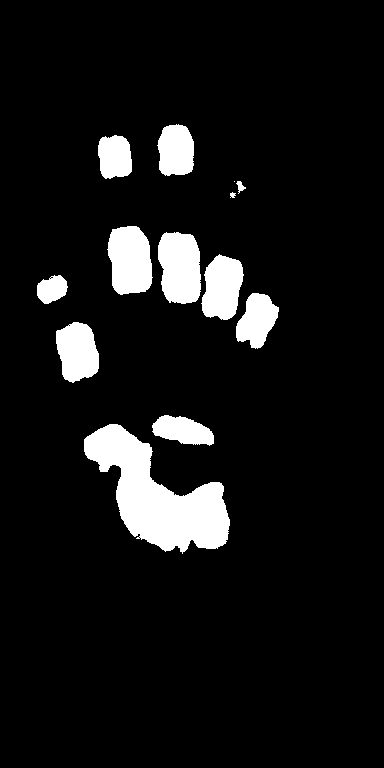

In [ ]:
  plt.imsave('test.png', np.squeeze(preds_train_t)[164])
  prediction = cv2.imread('test.png', 0)
  percentiles = np.percentile(prediction, (40, 99))
  prediction = exposure.rescale_intensity(prediction,
                                  in_range=tuple(percentiles))
  prediction = exposure.adjust_gamma(prediction, gamma=0.90,gain=1)
  cv2_imshow(prediction)

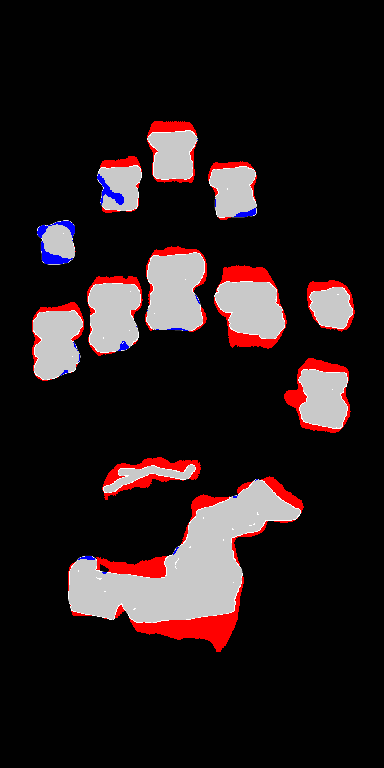

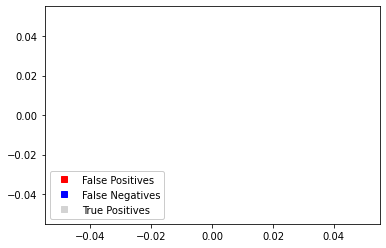

In [ ]:
index = 0
diffFP = cv2.subtract(clean_pred[index], Y_test[index])
diffFN = cv2.subtract(Y_test[index], clean_pred[index])
# cv2_imshow(diffFP)
# cv2_imshow(diffFN)
# cv2_imshow(Y_test[index])

cFP = cv2.cvtColor(diffFP,cv2.COLOR_GRAY2RGB)
indices = np.where(diffFP==255)
cFP[indices[0], indices[1], :] = [0, 0, 255]
# cv2_imshow(cFP)

cFN = cv2.cvtColor(diffFN,cv2.COLOR_GRAY2RGB)
indices = np.where(diffFN==255)
cFN[indices[0], indices[1], :] = [255, 0, 0]
# cv2_imshow(cFN)

newY = cv2.cvtColor(Y_test[index], cv2.COLOR_GRAY2RGB)
indices = np.where(Y_test[index]==255)
newY[indices[0], indices[1], :] = [200, 200, 200]
newY = cv2.addWeighted(newY, 1, cFP, 1,1)
indices = np.where(diffFN==255)
newY[indices[0], indices[1], :] = [255, 0, 0]
# newY = cv2.addWeighted(cFN, 1, newY, 0.5,1)
cv2_imshow(newY)
# cv2_imshow(cFN)
# _, mask = cv2.threshold(diffFP, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
# cFP[(mask==255).all(-1)] = [0,255,0]
# cv2_imshow(cv2.cvtColor(cFP, cv2.COLOR_BGR2RGB))


colors = ["red", "blue", "lightgray"]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(3)]
labels = ["False Positives", "False Negatives", "True Positives"]
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=True)

def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

In [ ]:
for i in range(10):
  plt.imshow(np.squeeze(X_test[i]))
  plt.show()
  plt.imshow(np.squeeze(preds_test_t)[i])
  plt.show()

SyntaxError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Average dice similarity: 0.8791286136247678
SD for dice similarity: 0.030038229757625906


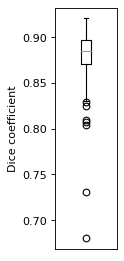

Number of outliers: 7


In [ ]:
# DICE coeficient calculation
import statistics
from skimage.metrics import structural_similarity as ssim

# Dice similarity function
# def dice(pred, true, k = 1):
#     intersection = np.sum(pred[true==k]) * 2.0
#     dice = intersection / (np.sum(pred) + np.sum(true))
#     return dice

# def dice(pred, true, k = 1):
#   diffFP = pred - true
#   diffFN = true - pred
#   TP2 = np.sum(pred - diffFP - diffFN) * 2.0
#   TP = pred - diffFP - diffFN
#   # cv2_imshow(TP)
#   # cv2_imshow(true - TP)
#   # cv2_imshow(diffFN)
#   dice = TP2 / (TP2 + np.sum(diffFP) + np.sum(diffFN))
#   return dice

# def dice(pred, true, k=1):
#   return ssim(true, pred)

# def dice(mask1, mask2):
#     intersect = np.sum(mask1*mask2)
#     fsum = np.sum(mask1)
#     ssum = np.sum(mask2)
#     dice = (2 * intersect ) / (fsum + ssum)
#     # dice = np.mean(dice)
#     # dice = round(dice, 3) # for easy reading
#     return dice  

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

Y_special = np.concatenate((Y_train, Y_test))
pred_special = np.concatenate((clean_pred_train, clean_pred_test))

avgDice = []
for i in range(len(Y_train)):
  pred = clean_pred_train[i]
  # pred = np.squeeze(preds_test_t)[i]
  true = Y_train[i]
  # pred = pred_special[i]
  # true = Y_special[i]
  avgDice.append(dice(pred, true))

dice_score = statistics.mean(avgDice)
sd_dice = statistics.stdev(avgDice)
print ("Average dice similarity: {}".format(dice_score))
print ("SD for dice similarity: {}".format(sd_dice))

from matplotlib.pyplot import figure

figure(figsize=(1, 4), dpi=80)
plt.boxplot(avgDice)
plt.xticks([])
plt.ylabel("Dice coefficient")
plt.show()

def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])
 
    # compute IRQ
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
 
    return outliers
 
print("Number of outliers: {}".format(len(detect_outlier((avgDice)))))

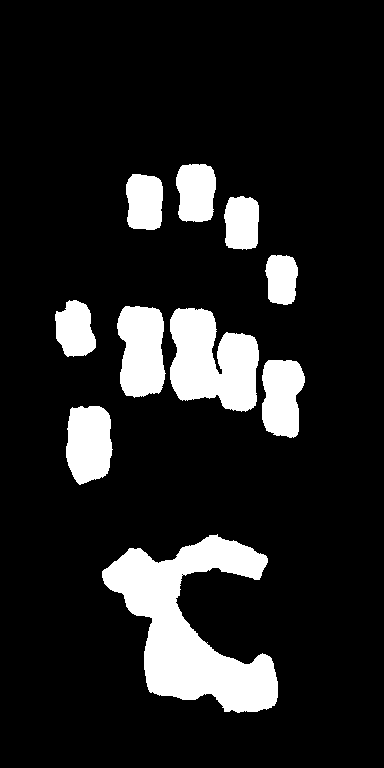

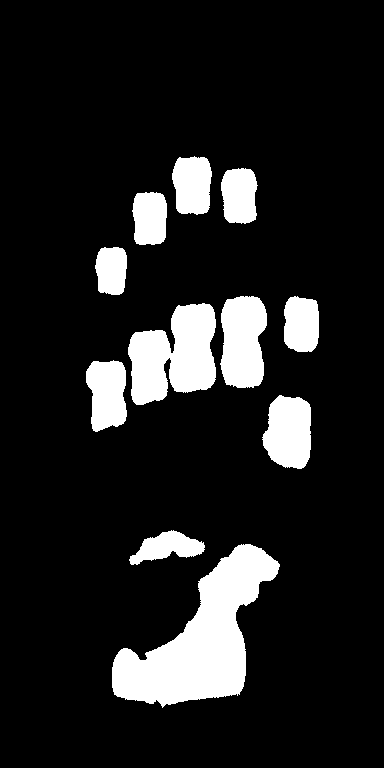

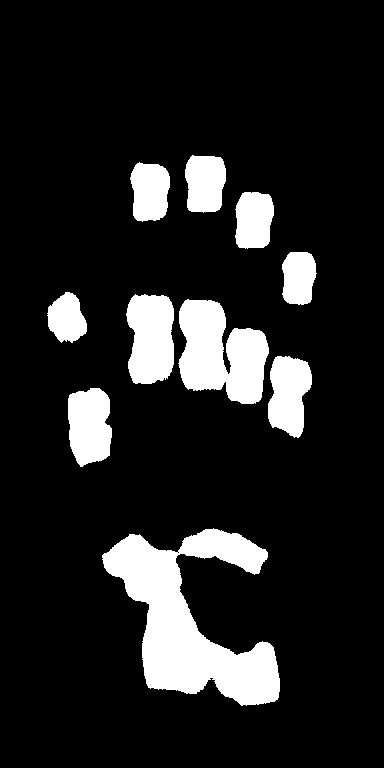

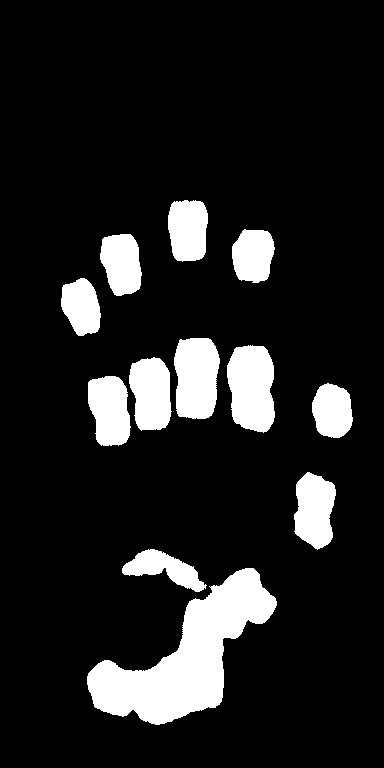

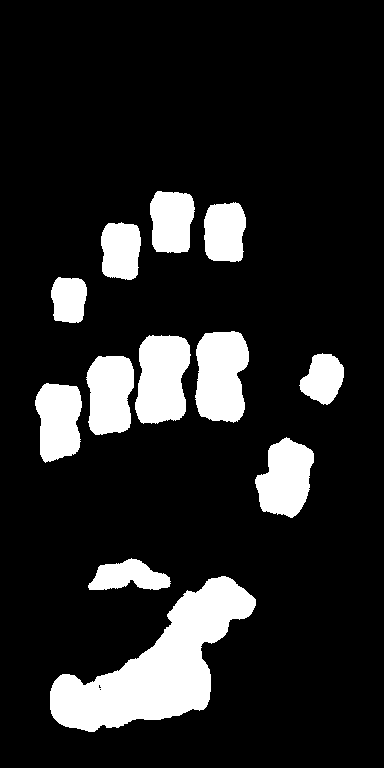

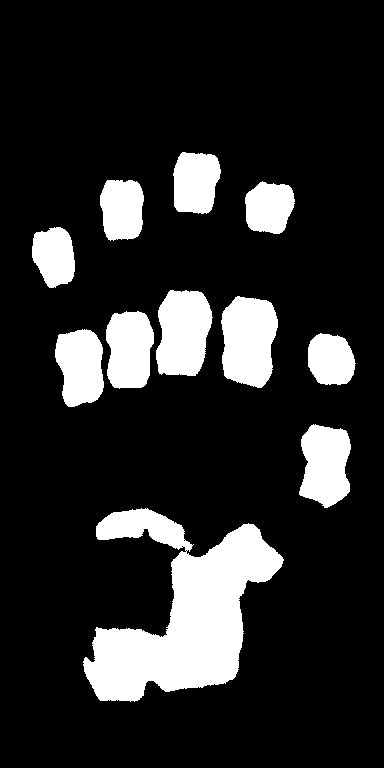

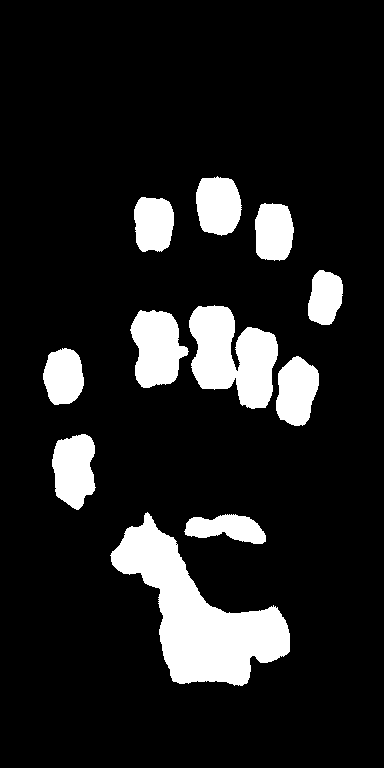

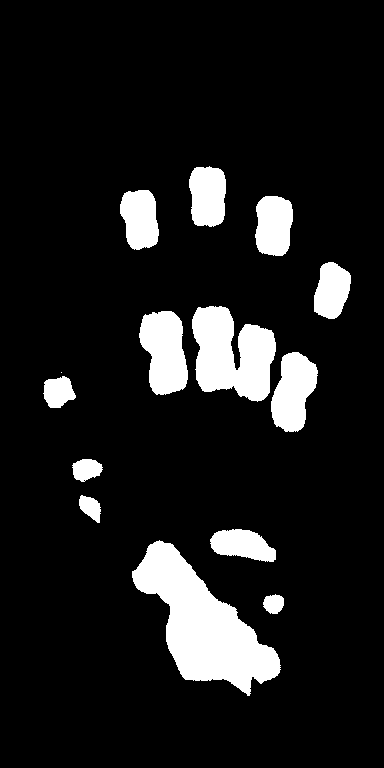

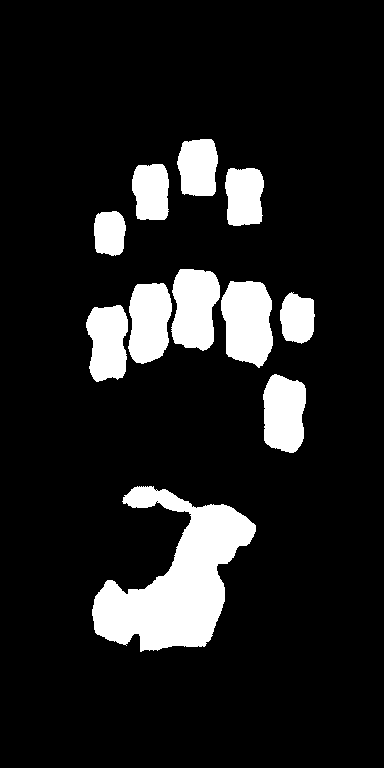

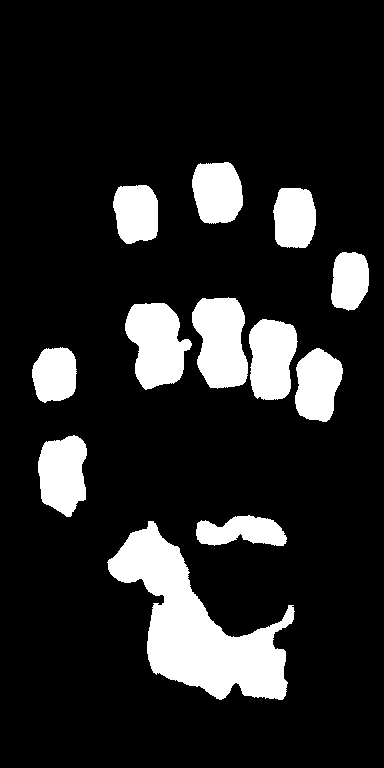

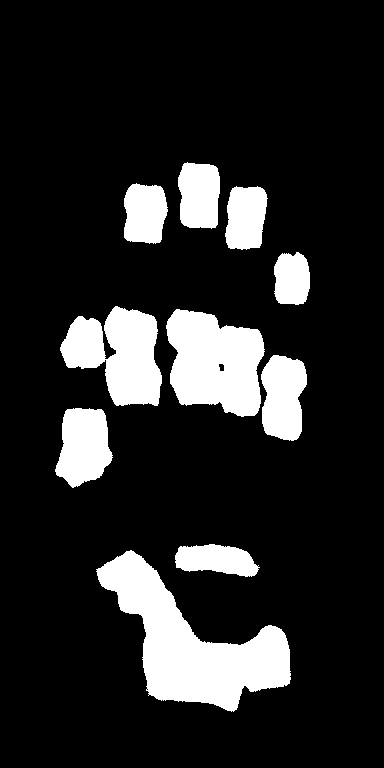

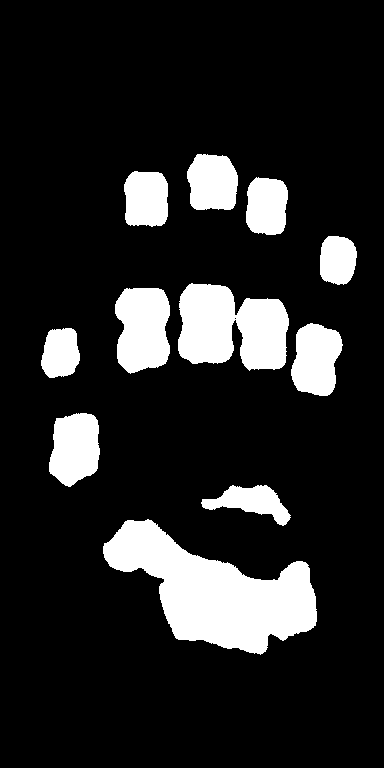

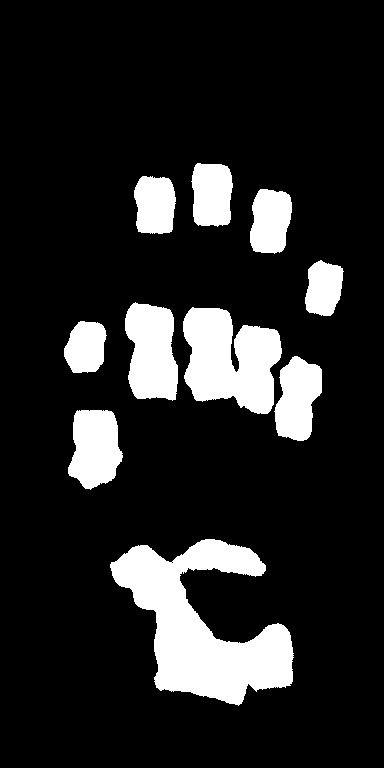

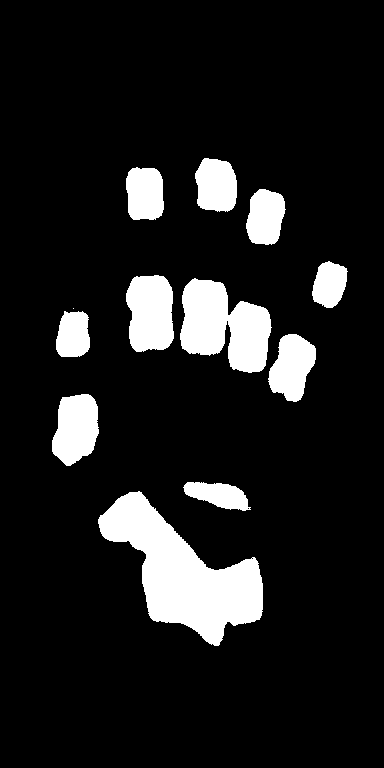

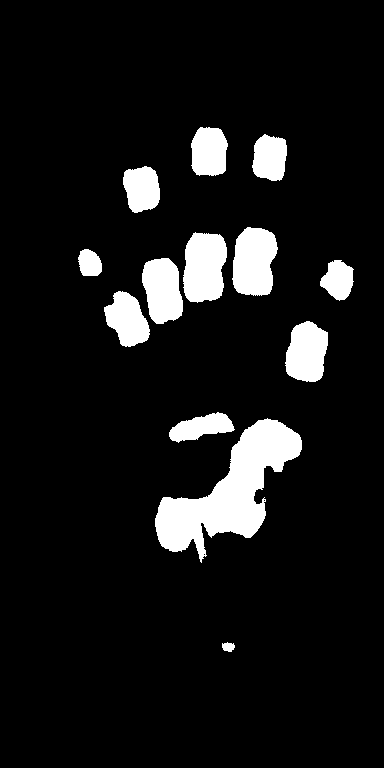

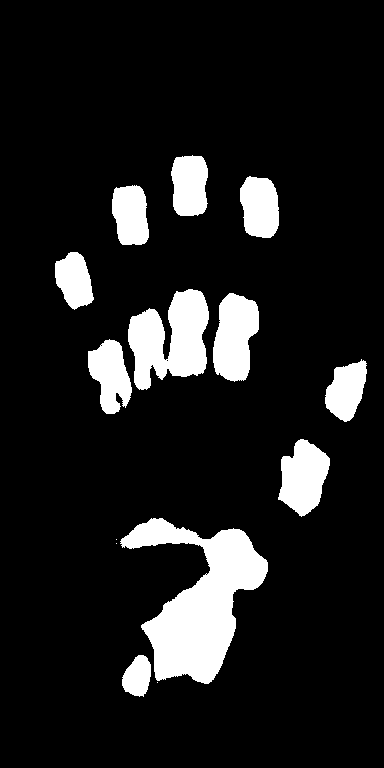

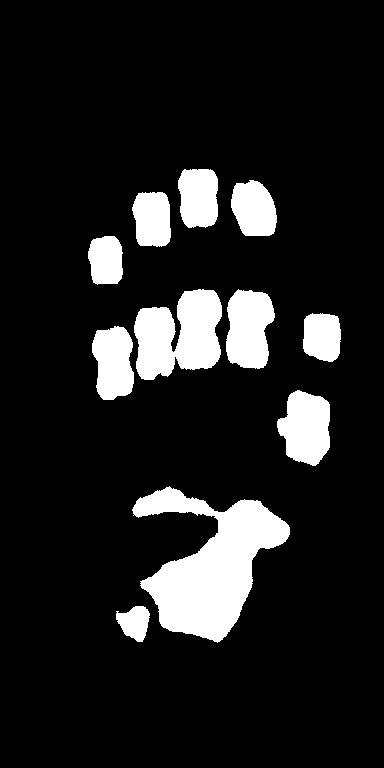

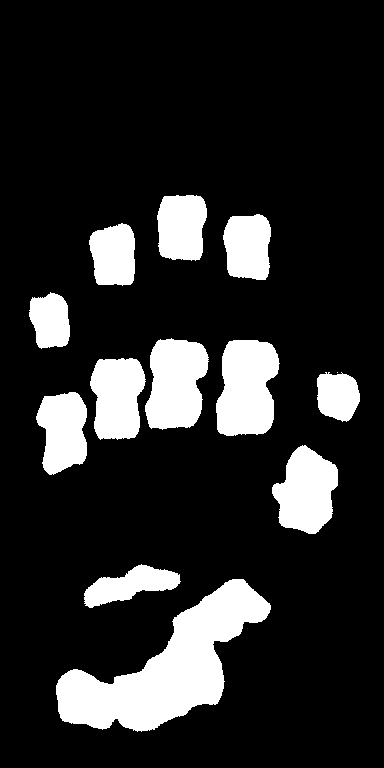

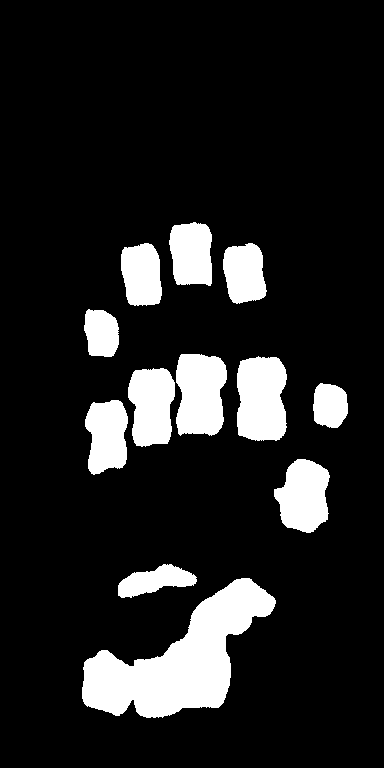

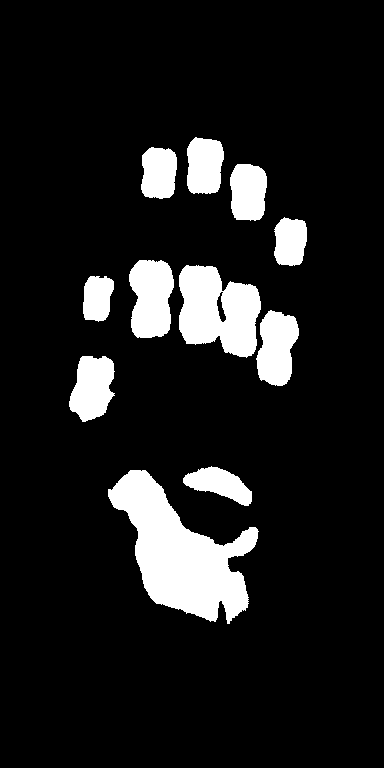

In [ ]:
# save = plt.imsave('test.png', np.squeeze(preds_train_t)[1])
# cv2_imshow(cv2.imread('test.png',0))
# cv2_imshow(clean_pred_train[1])

for i in range(20):
  cv2_imshow(clean_pred_train[i])

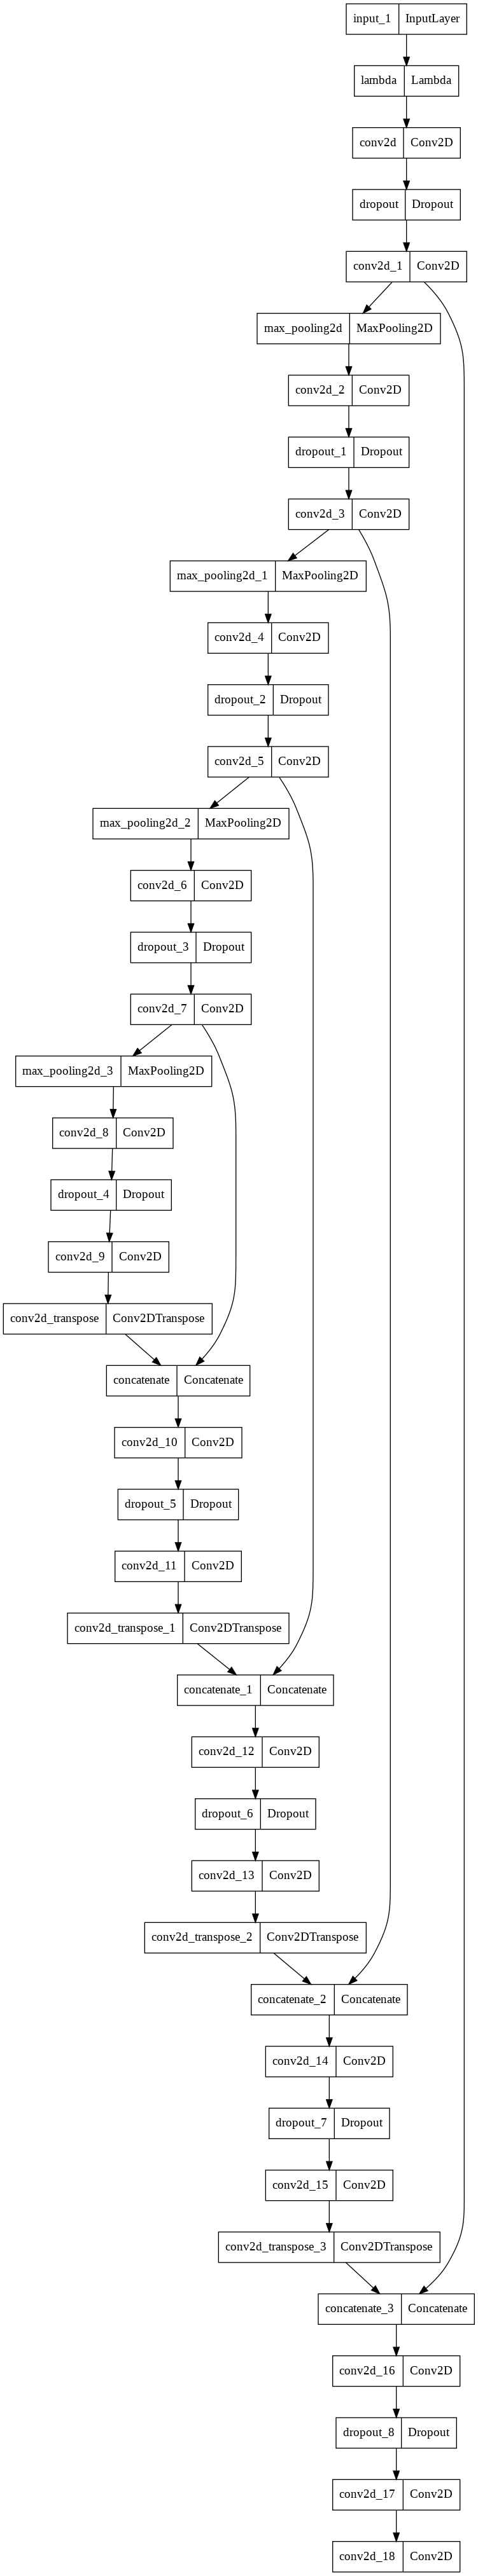

In [ ]:
# tf.saved_model.save(results, '/content/drive/MyDrive/Universiteit Utrecht - Drive/Stage')

savePath = '/content/drive/MyDrive/Universiteit Utrecht - Drive/Stage'

model.save(savePath + '/U4_T200_3x6(NEW).h5')
tf.keras.utils.plot_model(model, show_shapes=False)

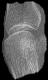

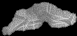

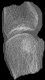

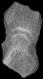

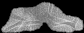

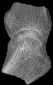

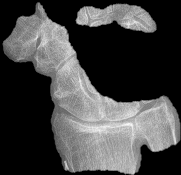

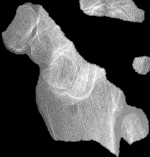

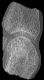

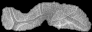

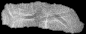

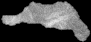

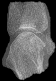

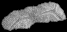

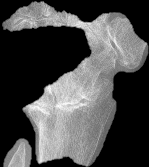

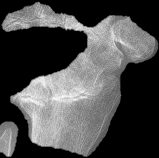

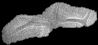

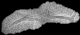

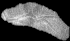

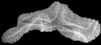

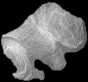

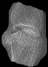

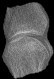

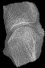

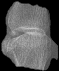

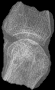

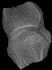

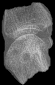

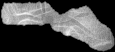

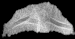

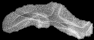

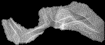

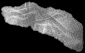

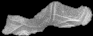

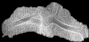

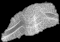

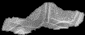

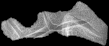

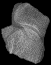

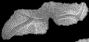

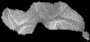

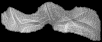

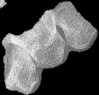

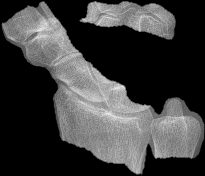

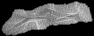

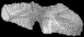

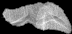

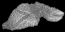

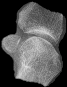

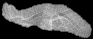

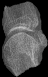

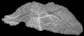

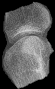

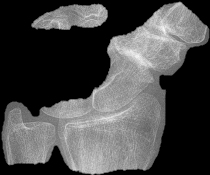

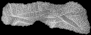

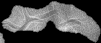

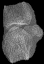

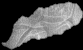

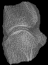

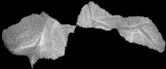

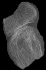

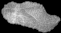

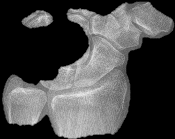

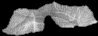

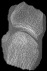

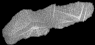

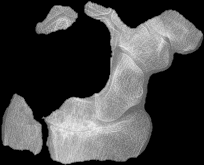

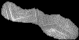

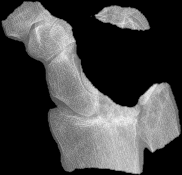

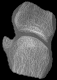

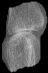

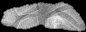

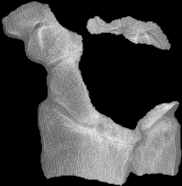

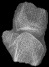

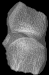

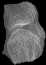

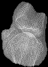

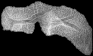

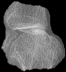

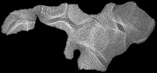

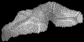

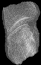

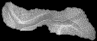

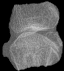

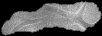

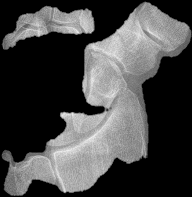

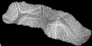

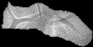

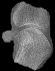

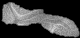

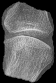

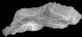

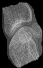

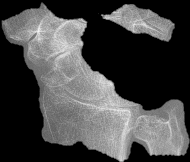

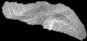

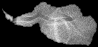

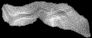

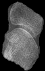

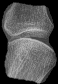

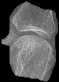

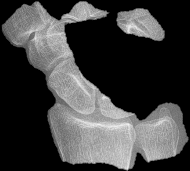

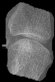

In [ ]:
from google.colab.patches import cv2_imshow
from scipy import stats
import sys

def postProcesROI (img, pred):
  # Load images
  image = img
  prediction = pred

  # Convert prediction into cv2 object
  plt.imsave('test.png', prediction)
  prediction = cv2.imread('test.png', 0)

  # Clean the prediction for close to zero pixel values (this cleans up the cut with the original image later)
  percentiles = np.percentile(prediction, (40, 99))
  prediction = exposure.rescale_intensity(prediction,
                                  in_range=tuple(percentiles))
  prediction = exposure.adjust_gamma(prediction, gamma=0.90,gain=1)

  # Blur the mask for cleaner end result (kind of optional tbh)
  blur = cv2.GaussianBlur(prediction, (3,3), 0)

  # Find all contours of the mask
  cnts = cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  # Calculate which generated contour is an outlier
  cnts_clean = []
  area_limit = 200
  # An area size of 200 is chosen since in all the training and test sets not a single contour 
  # of area > 200 and area < 1000 is found (whitch might've indicated very small joints but is never the case)
  for i in range(len(cnts)):
    area = cv2.contourArea(cnts[i])
    # Now remove the small outliers from the contour listing (this is for cropping later)
    if area > area_limit:
      cnts_clean.append(cnts[i])
    if area < area_limit:
      # Just to be sure; paint all small areas black as they are not joints 
      cv2.drawContours(blur, [cnts[i]], -1, (0,0,0), -1)
  
  # Cut image based on (inverted) mask
  invMask = cv2.bitwise_not(blur)
  result = cv2.subtract(image,invMask)

  singleJointOut = []
  for i in range(len(cnts_clean)):
    c = cnts_clean[i]
    left = tuple(c[c[:, :, 0].argmin()][0])
    right = tuple(c[c[:, :, 0].argmax()][0])
    top = tuple(c[c[:, :, 1].argmin()][0])
    bottom = tuple(c[c[:, :, 1].argmax()][0])
    singleJointOut.append(result[top[1]:bottom[1], left[0]:right[0]])

  # Combine the outermost parts of each contour to get the extreme points of the whole mask
  leftmost = sys.maxsize
  rightmost = 0
  topmost = sys.maxsize
  bottommost = 0
  for i in range(len(cnts_clean)):
    c = cnts_clean[i]
    left = tuple(c[c[:, :, 0].argmin()][0])
    right = tuple(c[c[:, :, 0].argmax()][0])
    top = tuple(c[c[:, :, 1].argmin()][0])
    bottom = tuple(c[c[:, :, 1].argmax()][0])
    
    leftmost = min(left[0], leftmost)
    rightmost = max(right[0], rightmost)
    topmost = min(top[1], topmost)
    bottommost = max(bottom[1], bottommost)  

  # Show / return result
  ROI = result[topmost:bottommost, leftmost:rightmost]
  # return cv2_imshow(ROI)
  return singleJointOut


#TODO: problems from test_set, index; 2 (still outliers (big!)), 0-3-5 (hole in prediction), 
for index in range(115):
  image = X_train[index]
  prediction = np.squeeze(preds_train_t[index])
  out = postProcesROI(image, prediction)
  cv2_imshow(out[1])
# cv2_imshow(image)

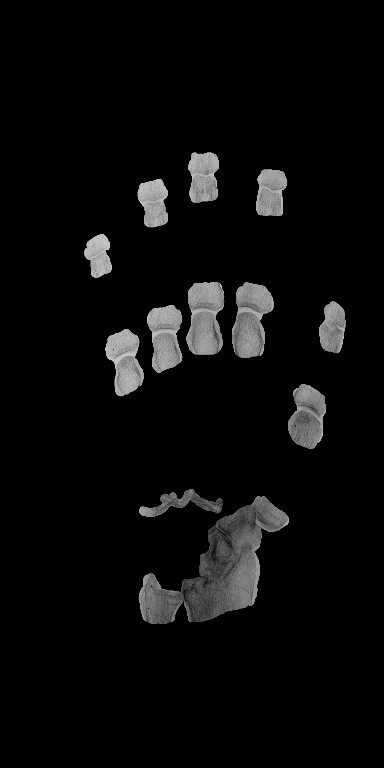

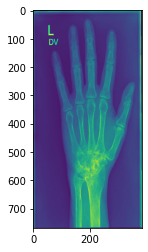

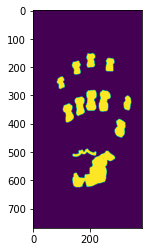

In [ ]:
import cv2

from google.colab.patches import cv2_imshow

path = TRAIN_PATH + "/" + "075" + "/"

image_name = next(os.walk(path))[2][0] # The [0] here indicates the original image
im = cv2.imread(path + image_name, 0) 
im = cv2.resize(im, (IMG_WIDTH, IMG_HEIGHT))


mask_name = next(os.walk(path))[2][1] # The [1] here indicates the mask image
mask = cv2.imread(path + mask_name, 0)  
mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
 

diff_im = cv2.subtract(mask, im)

cv2_imshow(diff_im)

plt.imshow(im)
plt.show()
plt.imshow(mask)
plt.show()

In [ ]:
visualkeras.layered_view(model, to_file='output.png', legend=True, scale_xy=1, scale_z=1, max_z=1000).show()